In [1]:
import seaborn as sns
import gc
import os
import sys
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from subprocess import check_output
import distance
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

In [28]:
train = pd.read_csv("train.csv")
print("Number of data points:",train.shape[0])
train = train.head(int(train.shape[0]*0.6))
print(train.shape)


Number of data points: 404290
(242574, 6)


In [29]:
print('Duplicate pairs: {}%'.format(train['is_duplicate'].mean()*100))
print('Non-Duplicate pairs: {}%'.format(np.mean(train['is_duplicate']==0)*100))

Duplicate pairs: 37.21544765720976%
Non-Duplicate pairs: 62.78455234279024%


In [33]:
total_questions = pd.concat([train['qid1'], train['qid2']], ignore_index=True) #pd.concat(df['qid1'], df['qid2'])

# Count the number of unique questions
unique_questions_count = total_questions.nunique()

# Count questions appearing multiple times
questions_appearing_multiple_times = (total_questions.value_counts() > 1).sum()

print('Total number of questions in the training data: {}'.format(unique_questions_count))
print('Number of questions that appear multiple times: {}'.format(questions_appearing_multiple_times))

Total number of questions in the training data: 354811
Number of questions that appear multiple times: 60713


(array([152299.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  90275.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

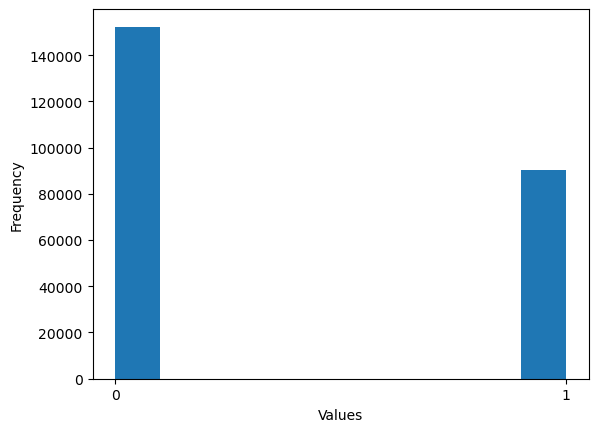

In [34]:
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xticks([0, 1])
plt.hist(train['is_duplicate'])

In [35]:
pair_duplicates = train[['qid1', 'qid2']].value_counts().reset_index(name='count')
number_of_duplicate_questions = (pair_duplicates['count'] > 1).sum()

print("Number of duplicate question pairs:", number_of_duplicate_questions)

Number of duplicate question pairs: 0


In [36]:
# Check for rows with NaN values
nan_rows = train[train.isna().any(axis=1)]
print(nan_rows)

            id    qid1    qid2                         question1 question2  \
105780  105780  174363  174364    How can I develop android app?       NaN   
201841  201841  303951  174364  How can I create an Android app?       NaN   

        is_duplicate  
105780             0  
201841             0  


In [37]:
train=train.dropna()

In [38]:
import re
import string
import contractions
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to C:\Users\Aniket
[nltk_data]     Tiwari\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [39]:
def preprocess_text(text):
    # Remove HTML tags using BeautifulSoup
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

    # Expand contractions
    text = contractions.fix(text)

    # Tokenize text
    words = text.split()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.lower() not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]

    # Join the processed words back into a single string
    processed_text = " ".join(words)

    return processed_text

# Example usage:
raw_text = "This is an <strong>example</strong> text with some punctuation and contractions like isn't and I'm. It also contains stopwords."
cleaned_text = preprocess_text(raw_text)
print(cleaned_text)


exampl text punctuat contract like also contain stopword


In [40]:
def word_share(data_point):
  question1 = data_point['question1'].lower().split()
  question2 = data_point['question2'].lower().split()
  common_words = set(question1) & set(question2)
  total_words = len(question1) + len(question2)
  share = len(common_words) / total_words
  return share
# print(train.apply(word_share, axis=1))


In [41]:
train['word_share'] = train.apply(word_share, axis=1)

In [42]:
print(train.shape)

(242572, 7)


In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming 'df' is your DataFrame and you have a column 'question1' and 'question2'
questions1 = train['question1'].tolist()
questions2 = train['question2'].tolist()

# Combine the two lists of questions
questions = np.concatenate((questions1, questions2))

# Initialize the TfidfVectorizer
tfidf = TfidfVectorizer(lowercase=False, )#(analyzer='word',stop_words = 'english', lowercase=False,sublinear_tf=True)# ngram_range=(1,6), stop_words = 'english', sublinear_tf=True)

# Fit and transform the questions
tfidf_matrix = tfidf.fit_transform(questions)

# Create a dictionary of word-to-TF-IDF scores
# word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [44]:
word2tfidf = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

In [45]:
tfidf_matrix.shape

(485144, 86498)

In [46]:
import spacy
!python -m spacy download en_core_web_lg
# !python -m spacy download en_core_web_sm
# !python -m spacy download en_core_web_md
!python -m spacy download en
nlp = spacy.load('en_core_web_lg')

     ---------------------------------------- 0.0/587.7 MB ? eta -:--:--
     ---------------------------------------- 0.0/587.7 MB ? eta -:--:--
     -------------------------------------- 0.1/587.7 MB 787.7 kB/s eta 0:12:26
     -------------------------------------- 0.1/587.7 MB 983.0 kB/s eta 0:09:58
     ---------------------------------------- 0.2/587.7 MB 1.4 MB/s eta 0:07:10
     ---------------------------------------- 0.4/587.7 MB 2.0 MB/s eta 0:05:00
     ---------------------------------------- 0.6/587.7 MB 2.2 MB/s eta 0:04:28
     ---------------------------------------- 1.0/587.7 MB 3.4 MB/s eta 0:02:52
     ---------------------------------------- 1.5/587.7 MB 4.0 MB/s eta 0:02:27
     ---------------------------------------- 1.9/587.7 MB 5.2 MB/s eta 0:01:54
     ---------------------------------------- 1.9/587.7 MB 5.2 MB/s eta 0:01:54
     ---------------------------------------- 2.6/587.7 MB 5.7 MB/s eta 0:01:44
     ---------------------------------------- 2.7/587.

In [47]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
# nlp = spacy.load('en_core_web_lg')
vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progrss bar
for qu1 in tqdm(list(train['question1'])):
    doc1 = nlp(qu1)
    # 384 is the number of dimensions of vectors
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
# train['q1_feats_m'] = list(vecs1)
# x=nlp('man')
# len(x.vector)

100%|██████████| 242572/242572 [48:19<00:00, 83.66it/s]  


In [48]:
q1_feats_m = pd.DataFrame(list(vecs1))

In [49]:
vecs2 = []
for qu2 in tqdm(list(train['question2'])):
    doc2 = nlp(qu2)
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
# train['q2_feats_m'] = list(vecs2)

100%|██████████| 242572/242572 [40:32<00:00, 99.72it/s] 


In [50]:
q2_feats_m = pd.DataFrame(list(vecs2))

In [51]:
print(q2_feats_m.shape)

(242572, 300)


In [84]:
train = train.drop(['question1','question2' ], axis=1)


In [86]:
print(train['is_duplicate'])

0         0
1         0
2         0
3         0
4         0
         ..
242569    0
242570    0
242571    1
242572    0
242573    0
Name: is_duplicate, Length: 242572, dtype: int64


In [93]:
q1_feats_m.columns = [f'q2_{col}' for col in q1_feats_m.columns]

In [94]:
print(q1_feats_m.columns)

Index(['q2_q2_0', 'q2_q2_1', 'q2_q2_2', 'q2_q2_3', 'q2_q2_4', 'q2_q2_5',
       'q2_q2_6', 'q2_q2_7', 'q2_q2_8', 'q2_q2_9',
       ...
       'q2_q2_290', 'q2_q2_291', 'q2_q2_292', 'q2_q2_293', 'q2_q2_294',
       'q2_q2_295', 'q2_q2_296', 'q2_q2_297', 'q2_q2_298', 'q2_q2_299'],
      dtype='object', length=300)


In [95]:
# train = train.dropna()
# q1_feats_m.columns = [f'q2_{col}' for col in q2_feats_m.columns]
train_final = pd.concat([train, q1_feats_m, q2_feats_m], axis=1)
train_final = train_final.dropna()
target = train_final['is_duplicate']
# train_final.columns = [f'new_{col}' if col != 'is_duplicate' else col for col in result.columns]

In [96]:
print(target.shape)
print(train_final.shape)
print(train.shape)
# print(train_final)

(242570,)
(242570, 605)
(242572, 5)


In [53]:
train_final = train_final.drop(['is_duplicate'],axis=1)

In [54]:
print(train_final.shape)

(242570, 606)


In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
# from sklearn.cross_validation import StratifiedKFold 
from sklearn.model_selection import KFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [104]:
X_train,X_test, y_train, y_test = train_test_split(train_final, target, stratify=target, test_size=0.2)

In [57]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (169799, 606)
Number of data points in test data : (72771, 606)


In [58]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6278423312269212 Class 1:  0.37215766877307876
---------- Distribution of output variable in train data ----------
Class 0:  0.3721674843000646 Class 1:  0.3721674843000646


In [59]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Log loss on Test Data using Random Model 0.8864750989009718


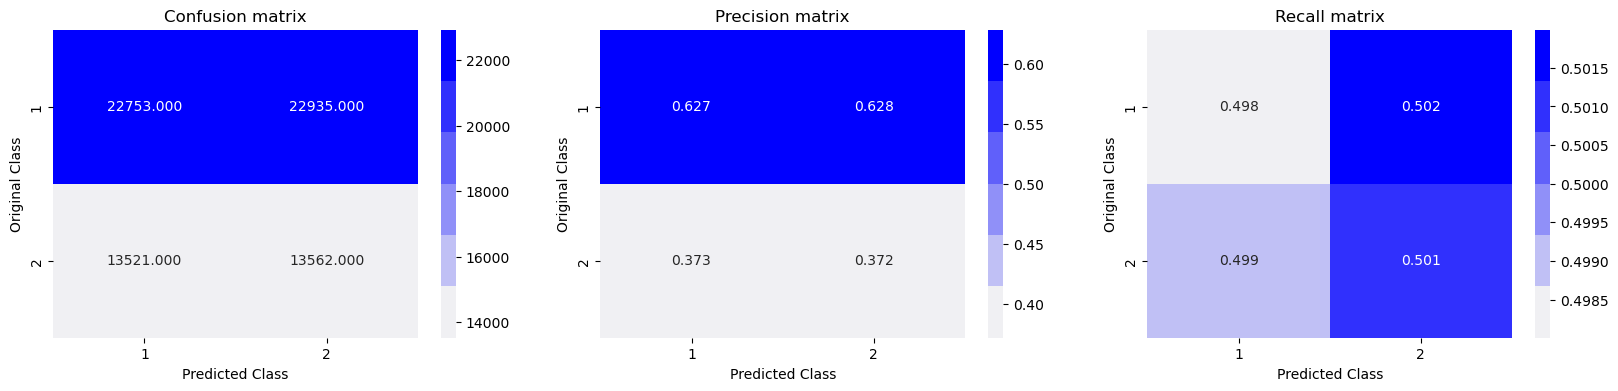

In [60]:
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

In [82]:
print(train_final)

             0         1         2    \
0            0.0       1.0       2.0   
1            1.0       3.0       4.0   
2            2.0       5.0       6.0   
3            3.0       7.0       8.0   
4            4.0       9.0      10.0   
...          ...       ...       ...   
242567  242567.0  354802.0  354803.0   
242568  242568.0  109189.0   49699.0   
242569  242569.0  354804.0  354805.0   
242570  242570.0  354806.0  354807.0   
242571  242571.0  354808.0  354809.0   

                                                      3    \
0       What is the step by step guide to invest in sh...   
1       What is the story of Kohinoor (Koh-i-Noor) Dia...   
2       How can I increase the speed of my internet co...   
3       Why am I mentally very lonely? How can I solve...   
4       Which one dissolve in water quikly sugar, salt...   
...                                                   ...   
242567  After my onsite interview at Facebook, i was a...   
242568  Can a person increase h

In [ ]:
X_train.columns =X_train.columns.astype(str)
X_test.columns =X_test.columns.astype(str)
X_train = X_train.drop(['question1','question2' ], axis=1)
X_test = X_test.drop(['question1','question2' ], axis=1)


For values of alpha =  1e-05 The log loss is: 0.6600991831649042
For values of alpha =  0.0001 The log loss is: 0.6600991831649042
For values of alpha =  0.001 The log loss is: 0.6600991831649042
For values of alpha =  0.01 The log loss is: 0.6600991831649042
For values of alpha =  0.1 The log loss is: 0.6111199106269848
For values of alpha =  1 The log loss is: 0.6011252285800409
For values of alpha =  10 The log loss is: 0.6168330899884251


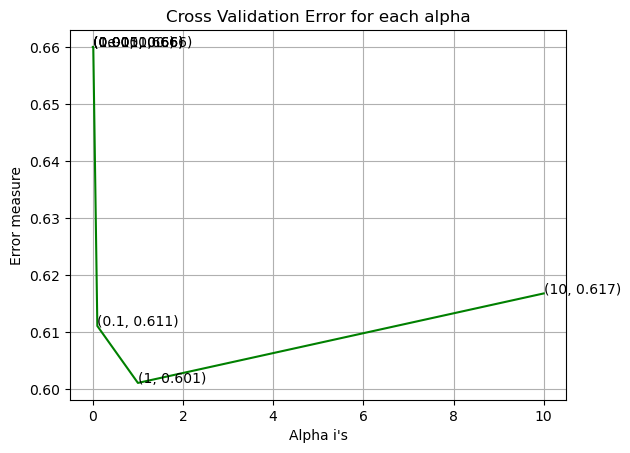

For values of best alpha =  1 The train log loss is: 0.6009369997476355
For values of best alpha =  1 The test log loss is: 0.6011252285800409
Total number of data points : 72771


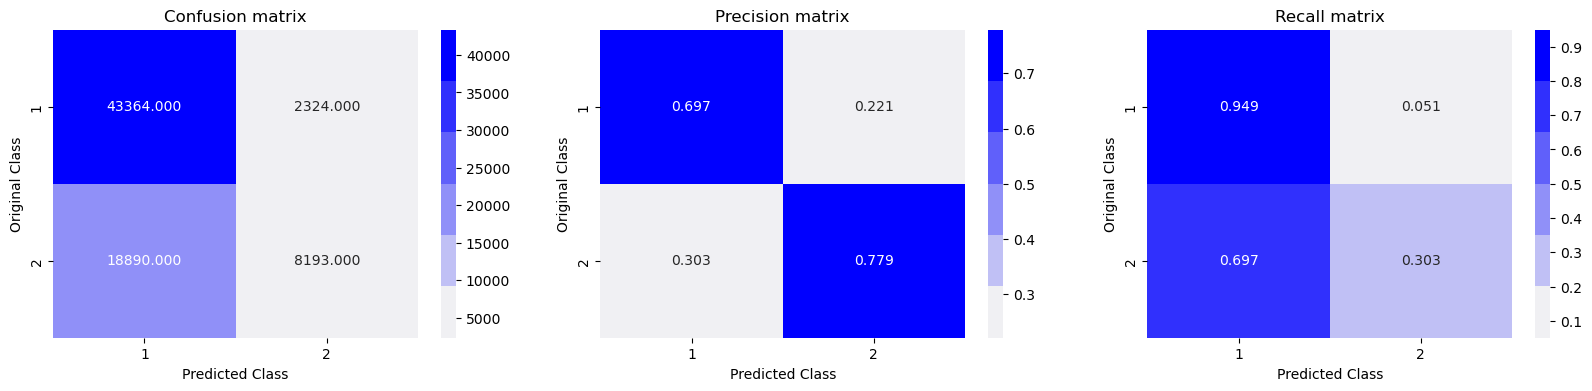

In [67]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

For values of alpha =  1e-05 The log loss is: 0.6600991831649042
For values of alpha =  0.0001 The log loss is: 0.6600991831649042
For values of alpha =  0.001 The log loss is: 0.6600991831649042
For values of alpha =  0.01 The log loss is: 0.6600991831649042
For values of alpha =  0.1 The log loss is: 0.6600991831649042
For values of alpha =  1 The log loss is: 0.6600991831649042
For values of alpha =  10 The log loss is: 0.6600991831649042


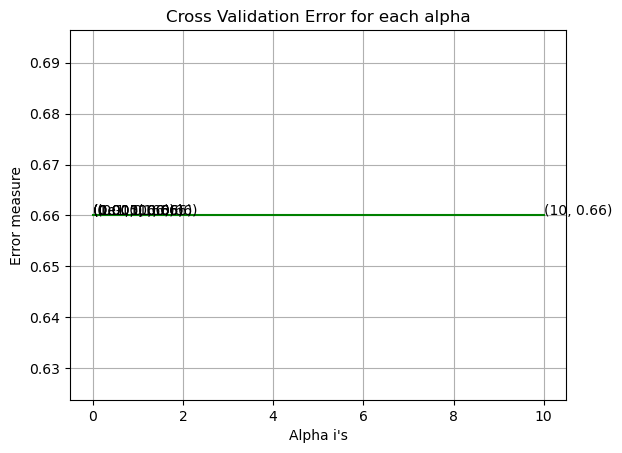

For values of best alpha =  1e-05 The train log loss is: 0.6600940502406413
For values of best alpha =  1e-05 The test log loss is: 0.6600991831649042
Total number of data points : 72771


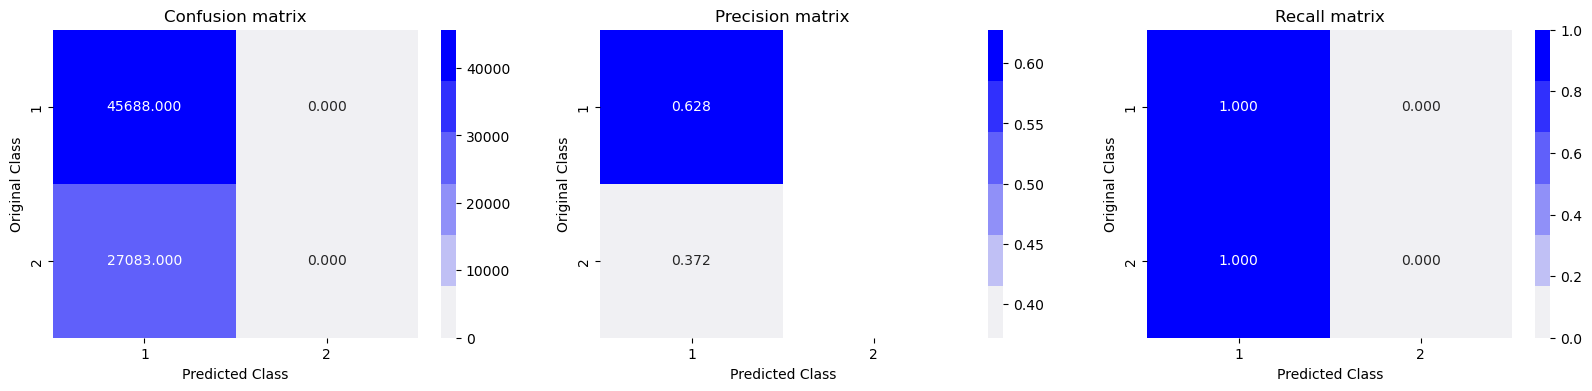

In [68]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [ ]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 2

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [102]:
print(X_train.shape)
print(X_train)


(169799, 605)
              id      qid1      qid2  is_duplicate  word_share     q2_q2_0  \
137131  137131.0  218616.0  218617.0           0.0    0.074074 -214.547126   
218012  218012.0   72701.0   14144.0           1.0    0.333333  -84.692936   
197679  197679.0  298698.0  298699.0           0.0    0.055556   15.623023   
189747  189747.0  136778.0  288597.0           0.0    0.384615    8.334248   
110075  110075.0   36185.0  180556.0           0.0    0.173913  -57.911249   
...          ...       ...       ...           ...         ...         ...   
34769    34769.0   63657.0   21884.0           1.0    0.416667   12.172323   
774        774.0    1543.0    1544.0           0.0    0.444444  -34.570980   
161537  161537.0  219077.0   93178.0           1.0    0.384615 -183.101750   
19970    19970.0   37714.0   37715.0           1.0    0.416667  -67.924695   
23721    23721.0   44402.0   44403.0           1.0    0.384615   41.059540   

           q2_q2_1     q2_q2_2    q2_q2_3     q2_

In [103]:
print(X_test.shape)
print(X_test)

(72771, 605)
              id      qid1      qid2  is_duplicate  word_share     q2_q2_0  \
26716    26716.0   49683.0   49684.0           0.0    0.117647  -61.392031   
28969    28969.0   53648.0   17743.0           1.0    0.333333   33.587496   
157629  157629.0   16430.0  246417.0           0.0    0.187500   -5.291120   
118249  118249.0  192241.0  192242.0           1.0    0.384615 -128.137945   
176274  176274.0  271248.0  271249.0           0.0    0.000000   51.426669   
...          ...       ...       ...           ...         ...         ...   
213550  213550.0  318904.0  318905.0           0.0    0.277778 -233.087757   
66842    66842.0   57441.0   50784.0           1.0    0.294118  -55.598898   
49766    49766.0   88534.0   88535.0           0.0    0.200000  -15.529222   
30505    30505.0   56331.0   56332.0           1.0    0.206897 -172.304236   
196189  196189.0  272190.0  164065.0           0.0    0.166667   36.374199   

           q2_q2_1     q2_q2_2     q2_q2_3     q2_